## African universities
This notebook is to obtain a comprehensive list of African universities form two different sources of data:
    _local csv file containing university information, which includes details such as university name, country, longitude and latitude.
    _universities library, which provides programmatic access to a vast collection of university information.
By combining data from these sources, the notebook aims to create a more complete and accurate list of African universities.

The resulting dataset can be used for various purposes, such as research, analysis, or generating insights into higher education across the African continent.

## local parquet file

In [1]:
import pandas as pd 
import warnings
import os

# Suppress FutureWarning and UserWarning messages
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
 
pd.set_option('display.max_colwidth', None)

program_df = df = pd.read_parquet('../data/parquet_data_universities.parquet')
program_df.head(2)


,name,country,longitude,latitude
0,University of Cape Town,South Africa,18.4719,-33.9628
1,Stellenbosch University,South Africa,18.8679,-33.9321


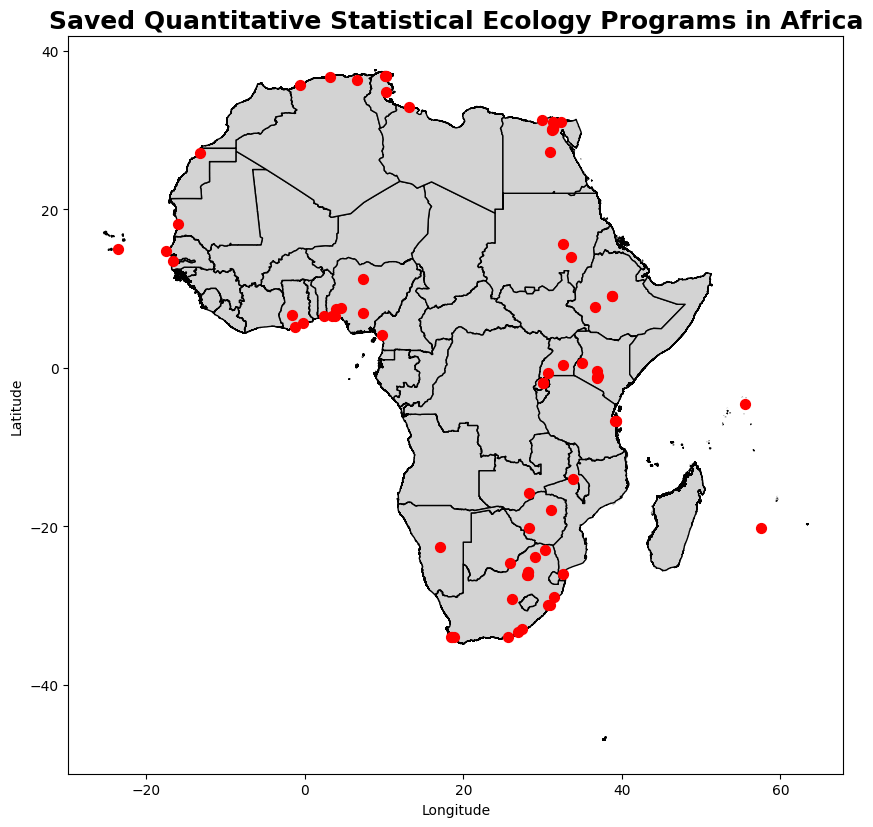

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
from scripts import map_plot
import os

# Get the current directory (path) of the notebook
notebook_path = os.getcwd()

# Specify the name of the child directory or file
child_name = "../afr_g2014_2013_0/afr_g2014_2013_0.shp"  # Replace with the desired child directory or file name

# Construct the path to the child directory or file
child_path = os.path.join(notebook_path, child_name)
 
 
africa_shapefile = child_path # Replace with the actual file path

map_plot(africa_shapefile,program_df,"Saved Quantitative Statistical Ecology Programs in Africa")

## Get daat using universities library

In [3]:
import universities

uni = universities.API()

all_data = uni.get_all()
df = pd.DataFrame(all_data)
df.rename(columns={0: 'data'}, inplace=True)

df.head()


,data
0,Name: Kharkiv National University\nCountry: Ukraine\nDomains:\n - student.karazin.ua\n - karazin.ua\nWeb Pages:\n - https://karazin.ua\n
1,Name: Universidad Técnica Federico Santa María\nCountry: Chile\nDomains:\n - usm.cl\nWeb Pages:\n - https://usm.cl\n
2,Name: IÉSEG School of Management\nCountry: France\nDomains:\n - ieseg.fr\nWeb Pages:\n - https://ieseg.fr\n
3,Name: Sun Yat-Sen University\nCountry: China\nDomains:\n - mail2.sysu.edu.cn\n - mail.sysu.edu.cn\nWeb Pages:\n - https://sysu.edu.cn\n
4,Name: Royal Holloway University of London\nCountry: United Kingdom\nDomains:\n - rhul.ac.uk\nWeb Pages:\n - https://rhul.ac.uk\n


In [4]:
data = list(df['data'].astype(str) )
   
# Create an empty list to collect data
rows = []

# Split the list elements by "\n" delimiter and create rows
for line in data:
    elements = line.strip().split("\n")
    row = {}
    for element in elements:
        if " - " in element:
            col, value = element.split(" - ", maxsplit=1)
            row[col] = value
        else:
            try:
                col, value = element.split(": ", maxsplit=1)
                row[col] = value
            except ValueError:
                # Handle lines that do not match the expected format
                pass
    rows.append(row)

# Create the DataFrame from the collected data
df_seap = pd.concat([pd.Series(row) for row in rows], axis=1).T

# Fill NaN values with an empty string
df_seap = df_seap.fillna("")
df_seap = df_seap[['Name', 'Country']]
# Print the resulting DataFrame
df_seap.head()


,Name,Country
0,Kharkiv National University,Ukraine
1,Universidad Técnica Federico Santa María,Chile
2,IÉSEG School of Management,France
3,Sun Yat-Sen University,China
4,Royal Holloway University of London,United Kingdom


##  get a list of countries in Africa using the "awoc" library

### Convert country name to its corresponding continent using pycountry_convert

Convert a given country name to its corresponding continent. We uses the pycountry_convert library to perform the conversion. The function, named country_to_continent, takes a country name as input and returns the continent name as output.

In [5]:
import pandas as pd
from geopy.geocoders import Nominatim

# Assuming you have a DataFrame named 'df' with a column named 'Country' containing the country names

# Function to get the continent from the country name
def get_continent(country_name):
    try:
        geolocator = Nominatim(user_agent="continent-finder")
        location = geolocator.geocode(country_name, exactly_one=True)
        if location is not None:
            return location.raw['address']['continent']
        else:
            return 'Unknown'
    except Exception:
        return 'Unknown'

# Apply the get_continent function to the 'Country' column and store the result in the 'Continent' column
df_seap['Continent'] = df_seap['Country'].apply(get_continent)
df_seap

,Name,Country,Continent
0,Kharkiv National University,Ukraine,Unknown
1,Universidad Técnica Federico Santa María,Chile,Unknown
2,IÉSEG School of Management,France,Unknown
3,Sun Yat-Sen University,China,Unknown
4,Royal Holloway University of London,United Kingdom,Unknown
...,...,...,...
9929,Texas Wesleyan University,United States,Unknown
9930,Howest University of Applied Sciences,Belgium,Unknown
9931,Nazarbayev University,Kazakhstan,Unknown
9932,St. George's University (Australia),Australia,Unknown


## filter African Univeristies

In [6]:
df_africa = df_seap[df_seap['Continent'].str.contains('Africa')]
# Reindex the DataFrame
df_africa = df_africa.reset_index(drop=True)

df_africa

,Name,Country,Continent


## get location coordnates

In [7]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

def add_coordinates(df, uni_address_column, coun_address_column):
    geolocator = Nominatim(user_agent="university-locator")
    df['Latitude'] = None
    df['Longitude'] = None

    def geocode_with_timeout(address):
        try:
            location = geolocator.geocode(address)
            return location
        except GeocoderTimedOut:
            return geocode_with_timeout(address)
        except Exception as e:
            # print(f"Geocoding error for address '{address}': {str(e)}")
            return None

    for index, row in df.iterrows():
        uni_address = row[uni_address_column]
        coun_address = row[coun_address_column]
        location = geocode_with_timeout(uni_address)

        if location is None:
            location = geocode_with_timeout(coun_address)

        if location:
            df.at[index, 'latitude'] = location.latitude
            df.at[index, 'longitude'] = location.longitude

    return df

try:
    df_with_coordinates = pd.read_parquet('df_with_coordinates.parquet')
except FileNotFoundError:
    df_with_coordinates = add_coordinates(df_africa, 'Name', 'Country')

    df_with_coordinates.to_parquet('df_with_coordinates.parquet')

 

df_with_coordinates = df_with_coordinates.drop("Country", axis=1)
df_with_coordinates = df_with_coordinates.rename(columns={'Country (English)': 'country','Name': 'name','Latitude': 'latitude','Longitude': 'longitude','Continent': 'continent'})
df_with_coordinates.head()

,name,country,continent,latitude,longitude
0,Université Amar Telidji,Algeria,Africa,33.799997,2.852186
1,Université M'hamed Bouguerra de Boumerdes,Algeria,Africa,28.000027,2.999983
2,Université Mentouri Constantine,Algeria,Africa,36.339137,6.622462
3,Université Mouloud Mammeri de Tizi Ouzou,Algeria,Africa,36.697899,4.057747
4,Université d'Alger 3,Algeria,Africa,36.757128,2.984307


## find none values if there are any

In [8]:
def find_none_values(df):
    null_rows = df[df['latitude'].isnull() & df['longitude'].isnull()]
    return null_rows
none_values_df = find_none_values(df_with_coordinates)
none_values_df

,name,country,continent,latitude,longitude


## concatenate the two DataFrames together

In [9]:
dff_loc = pd.read_parquet('add_universities_data.parquet')
dff_loc = dff_loc.rename(columns={'Latitude': 'latitude','Longitude': 'longitude'})
 
concatenated_df = pd.concat([df_with_coordinates, program_df,dff_loc], ignore_index=True)
concatenated_df

,name,country,continent,latitude,longitude
0,Université Amar Telidji,Algeria,Africa,33.799997,2.852186
1,Université M'hamed Bouguerra de Boumerdes,Algeria,Africa,28.000027,2.999983
2,Université Mentouri Constantine,Algeria,Africa,36.339137,6.622462
3,Université Mouloud Mammeri de Tizi Ouzou,Algeria,Africa,36.697899,4.057747
4,Université d'Alger 3,Algeria,Africa,36.757128,2.984307
...,...,...,...,...,...
905,University of Gemena,DRC,Africa,-2.981434,23.822264
906,University of Gandajika,DRC,Africa,-2.981434,23.822264
907,University of Isiro,DRC,Africa,-2.981434,23.822264
908,University of Kalemie,DRC,Africa,-2.981434,23.822264


## plot

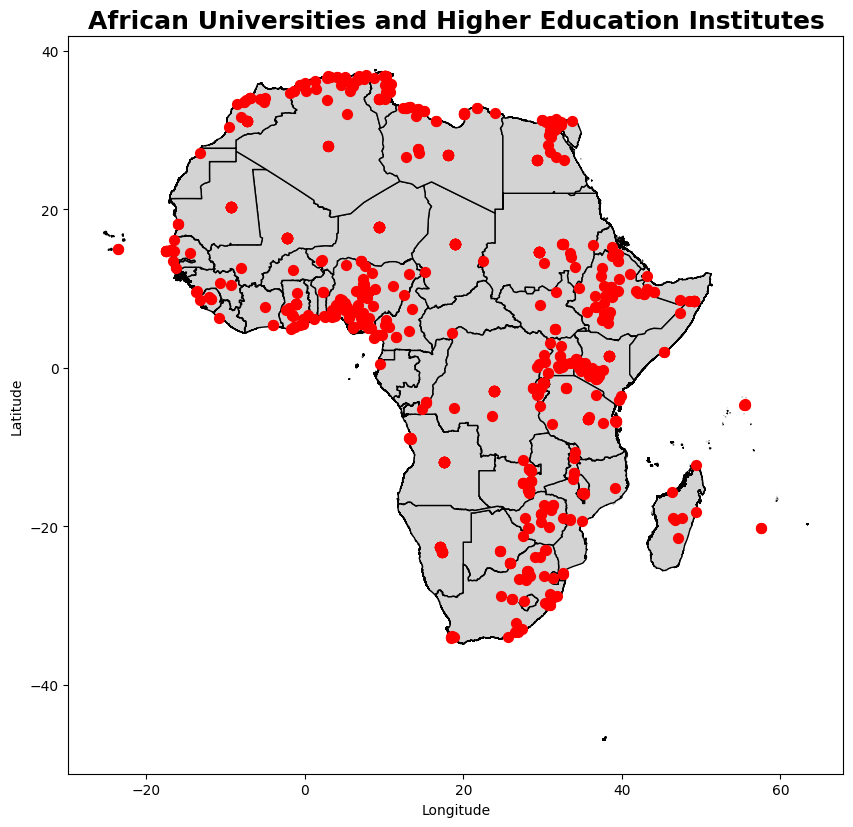

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
from scripts import map_plot


map_plot(africa_shapefile,concatenated_df,"African Universities and Higher Education Institutes")